# Espectro de un conjunto de transmons con PBC
Hacemos una cadena de transmons cada uno acoplado capacitivamente a sus primeros vecinos y conectamos el último con el primero de tal forma que:
$$
\hat H = \sum_j \hat H_j - \sum_j \hbar \tilde{g}_{j, j+1} (\hat b_j ^\dag - \hat b_j) (\hat b_{j+1}^\dag - \hat b_{j+1})
$$
Siendo $\hat H_j$ el hamiltoniano del transmon en la posición $j$ y 
$$
\hbar \tilde{g}_{j, j+1} = \frac{\left(E_J^j E_J^{j+1} (E_c^j E_c^{j+1})^3\right)^{1/4}}{\sqrt{2} E_c^{j, j+1}}
$$
con $E_c^{j, j+1} = \frac{e^2}{C_{j \rightarrow j+1}}$ la energía de carga asociada al capacitor de acople entre ambos sitios. Para simplificar las cuentas, primero consideraremos que todos los transmons tienen las mismas energías de Josephson y de carga, además que los capacitores de acople son todos iguales. 

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import qutip as qt
from scipy.special import genlaguerre, gammaln
import scienceplots
plt.style.use(['science', 'notebook'])

In [3]:
# expresion analitica para la matriz (en base de fock) del operador e^{i u (\hat a + \hat a^\dag)}
# def compute_position_exponential(N, u): 
#   matrix = np.zeros(shape= (N, N), dtype = complex)
#   for m in range(N):
#     for n in range(N):
#       if m >= n:
#         matrix[m][n] = np.exp(-u**2/2) * np.sqrt(factorial(n)/factorial(m)) * (1.0j*u)**(m-n)*genlaguerre(n, m-n)(u**2)
#       else:
#         matrix[m][n] = np.exp(-u**2/2) * np.sqrt(factorial(m)/factorial(n)) * (1.0j*u)**(n-m)*genlaguerre(m, n-m)(u**2)

#   return qt.Qobj(matrix)

def compute_position_exponential(N, u): 
  matrix = np.zeros(shape=(N, N), dtype=complex)
  for m in range(N):
    for n in range(N):
      if m >= n:
        matrix[m][n] = (
          np.exp(-u**2/2)
          * np.exp(0.5 * (gammaln(n+1) - gammaln(m+1)))
          * (1.0j*u)**(m-n)
          * genlaguerre(n, m-n)(u**2)
        )
      else:
        matrix[m][n] = (
          np.exp(-u**2/2)
          * np.exp(0.5 * (gammaln(m+1) - gammaln(n+1)))
          * (1.0j*u)**(n-m)
          * genlaguerre(m, n-m)(u**2)
        )

  return qt.Qobj(matrix)

# hamiltoniano exacto con dimensión truncada en N estados de Fock
def exact_transmon_hamiltonian(N, E_c, E_j):
    charge_number = 0.5j * (E_j/(2*E_c))**0.25 * (qt.destroy(N).dag() - qt.destroy(N))
    phase_prefactor = (2 * E_c / E_j)**0.25
    cos_delta = 0.5 * (compute_position_exponential(N, phase_prefactor) + compute_position_exponential(N, -phase_prefactor))
    return 4 * E_c * charge_number**2 - E_j * cos_delta

# términos para el término de orden 4
def O_0(N):
  return 6 * qt.destroy(N).dag()**2 * qt.destroy(N)**2 + 12 * qt.num(N)

def O_2(N):
  return 4 * (qt.destroy(N).dag()**3 * qt.destroy(N) + qt.destroy(N).dag() * qt.destroy(N)**3) + 6 * (qt.destroy(N)**2 + qt.destroy(N).dag()**2)

def O_4(N):
  return qt.destroy(N)**4 + qt.destroy(N).dag()**4

In [7]:
# hamiltoniano de una cadena de transmons con PBC, N = dimension del espacio de Fock de cada transmon, 
# n = numero de transmons, E_g = energia de carga del coupler

def exact_transmon_chain(N, n, E_c, E_J, E_g):
    op_list = [qt.qeye(N) for _ in range(n)]
    full_hamiltonian = qt.tensor(0.0 * qt.tensor(op_list))
    # suma de hamiltonianos actuando sobre cada uno de los transmon por separado
    for j in range(n):
        op_list[j] = exact_transmon_hamiltonian(N, E_c, E_J)
        full_hamiltonian += qt.tensor(op_list)
        op_list[j] = qt.qeye(N)
    hbar_g = (E_J * E_c**3)**0.5 / (np.sqrt(2) * E_g)
    # sumamos términos de acoplamiento
    for j in range(n-1):
        op_list[j] = (qt.destroy(N).dag() - qt.destroy(N))
        op_list[j+1] = (qt.destroy(N).dag() - qt.destroy(N))
        full_hamiltonian -= hbar_g * qt.tensor(op_list)
        op_list[j] = qt.qeye(N)
    op_list[0] = (qt.destroy(N).dag() - qt.destroy(N))
    full_hamiltonian -= hbar_g * qt.tensor(op_list)
    
    return full_hamiltonian

def approximate_transmon_chain(N, n, E_c, E_J, E_g):
    op_list = [qt.qeye(N) for _ in range(n)]
    full_hamiltonian = qt.tensor(0.0 * qt.tensor(op_list))
    # suma de hamiltonianos actuando sobre cada uno de los transmon por separado
    approximate_hamiltonian = np.sqrt(8 * E_c * E_J) * qt.num(N) - (E_c / 12.0) * (O_0(N) + O_2(N))
    for j in range(n):
        op_list[j] = approximate_hamiltonian
        full_hamiltonian += qt.tensor(op_list)
        op_list[j] = qt.qeye(N)
    hbar_g = (E_J * E_c**3)**0.5 / (np.sqrt(2) * E_g)
    # sumamos términos de acoplamiento
    for j in range(n-1):
        op_list[j] = (qt.destroy(N).dag() - qt.destroy(N))
        op_list[j+1] = (qt.destroy(N).dag() - qt.destroy(N))
        full_hamiltonian -= hbar_g * qt.tensor(op_list)
        op_list[j] = qt.qeye(N)
    op_list[0] = (qt.destroy(N).dag() - qt.destroy(N))
    full_hamiltonian -= hbar_g * qt.tensor(op_list)
    
    return full_hamiltonian

In [33]:
N = 8
n = 4
E_c = 1.0
E_j_values = np.linspace(40.0, 60.0, 20)
E_g = 0.5 
energies = []
for E_j in E_j_values:
    hamilitonian = exact_transmon_chain(N, n, E_c, E_j, E_g)
    energies.append(np.array(hamilitonian.eigenenergies()))

energies = np.array(energies)

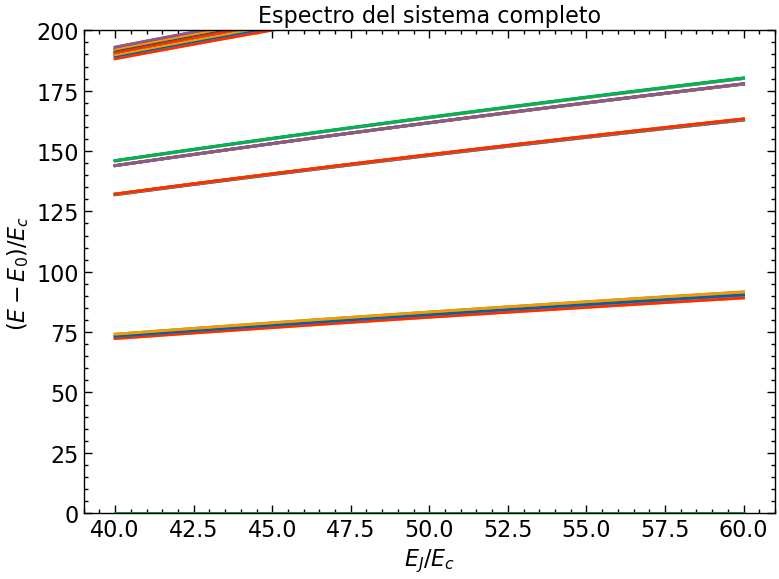

In [36]:
for bands in energies.T:
    plt.plot(E_j_values, bands-energies.T[0])

y_min = 0.0
y_max = 200
plt.ylim(y_min, y_max)
plt.xlabel('$E_J/E_c$')
plt.ylabel('$(E - E_0) / E_c$ ')
plt.title('Espectro del sistema completo')
plt.tight_layout()